# Analysis for RateYourMusic data

This notebook contains basic analysis for RateYourMusic data fetched by [rym_data_collection.py](../../data_processing/fetch/rym/rym_data_collection.py) with rymscraper package.

---
### Table of Contents
1. Analysis of raw RYM data
2. Album rating analysis
3. Genres analysis
---


## 0. Init


In [23]:
# Imports
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy

sys.path.append('../../')
from shared_utils.utils import PROJECT_DIR
from notebooks.exploratory._exploratory_utils import (
    scale_ratings,
    plot_box_plots,
    plot_ascii_chart
)

In [24]:
# Input variables
RYM_INPUT_PATH = f'{PROJECT_DIR}/data/raw/rym/rym_charts.csv'
PROCESSED_RYM_INPUT_PATH = f'{PROJECT_DIR}/data/processed/rym/rym_charts.csv'
df_raw_rym = pd.read_csv(RYM_INPUT_PATH)
df_rym = pd.read_csv(PROCESSED_RYM_INPUT_PATH)

## 1. Basic analysis of raw RYM data
- Example data
- Check empty values
- Check duplicates
- Check unique values
- Check foreign chars in album and artist name


In [25]:
# Example data
print('Example data:')
df_raw_rym.head()

Example data:


,artist,album,date,rating,ratings_number,genres
0,The Beatles,Rubber Soul,3 December 1965,4.03,"38,926",Pop Rock
1,Bob Dylan,Highway 61 Revisited,30 August 1965,4.18,"29,606","Folk Rock, Singer-Songwriter"
2,John Coltrane,A Love Supreme,February 1965,4.31,"29,467","Spiritual Jazz, Avant-Garde Jazz"
3,The Beatles,Help!,6 August 1965,3.65,"23,942",Pop Rock
4,Bob Dylan,Bringing It All Back Home,22 March 1965,4.11,"18,776","Folk Rock, Singer-Songwriter, Contemporary Folk"


In [26]:
# Count empty values
pd.DataFrame(df_raw_rym.isna().sum(), columns=['Empty values'])

,Empty values
artist,4
album,2
date,1
rating,24
ratings_number,0
genres,959


In [27]:
# Duplicates
print(f'Number of duplicated albums by name and artist: '
      f"{df_raw_rym.duplicated(subset=['artist', 'album']).sum()}")
df_raw_rym[df_raw_rym.duplicated(subset=['artist', 'album'], keep=False)].sort_values(by=['artist'])

Number of duplicated albums by name and artist: 35242


,artist,album,date,rating,ratings_number,genres
80887,Aburadako [あぶらだこ],あぶらだこ (Aburadako),1988,3.19,370,Art Punk
82323,Aburadako [あぶらだこ],あぶらだこ (Aburadako),10 April 1989,3.41,130,"Brutal Prog, Post-Hardcore, Art Punk"
73665,Akiko Yano [矢野顕子],ただいま。 (Tadaima.),1 May 1981,3.69,"1,897","Art Pop, Techno kayō"
72817,Akiko Yano [矢野顕子],ごはんができたよ (Gohan ga Dekita yo),1 October 1980,3.75,467,"Progressive Pop, Art Pop"
14770,Akiko Yano [矢野顕子],ごはんができたよ (Gohan ga Dekita yo),1 October 1980,3.75,467,"Progressive Pop, Art Pop"
...,...,...,...,...,...,...
31765,피치카도 화이브,Happy End of the World,9 September 1997,3.51,944,Shibuya-kei
53282,NaN,Life Has Gone On Long Enough,11 April 2018,3.49,348,"Atmospheric Black Metal, Depressive Black Metal"
53913,NaN,Damp Chill of Life,11 April 2019,3.65,888,"Atmospheric Black Metal, Depressive Black Metal"
111549,NaN,Life Has Gone On Long Enough,11 April 2018,3.49,348,"Atmospheric Black Metal, Depressive Black Metal"


In [28]:
# Count uniques
pd.DataFrame(df_raw_rym.nunique(), columns=['Unique values'])

,Unique values
artist,33518
album,72678
date,11493
rating,369
ratings_number,5950
genres,18400


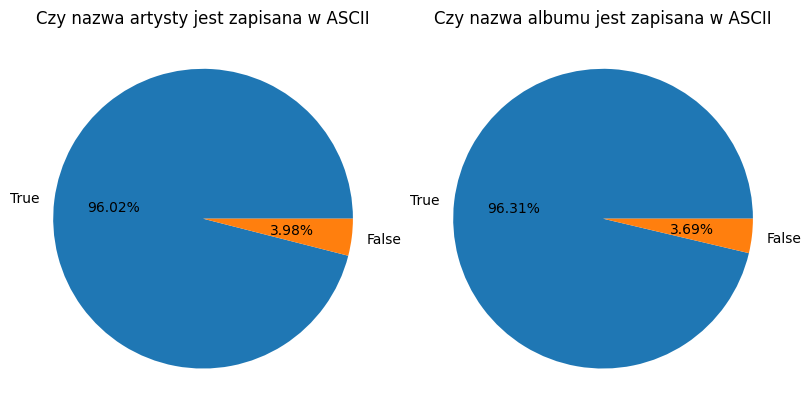

In [29]:
# Check for unusual characters
plot_ascii_chart(df_raw_rym)

### Conclusion

- Duplicates need to be removed.
- Date column need to be converted into datetime format.
- Convert rating number into int.
- Rating number below 50 ratings will be dropped.
- Albums without genre will be dropped.
- Some artist and albums contains non-ascii characters. This may lead to **problem in searching by names in Spotify API**, as Spotify often use simplified version of a name.

## 2. Album rating analysis
- Insight in original rating from RYM
- Scale and cut ratings for better distribution

### 2.1 Stats for original rating from RYM

In [30]:
print(f'IQR: {scipy.stats.iqr(df_rym.rating).round(3)}')
df_rym['rating'].describe()

IQR: 0.32


count    68160.000000
mean         3.360973
std          0.324769
min          0.580000
25%          3.240000
50%          3.420000
75%          3.560000
max          4.340000
Name: rating, dtype: float64

<AxesSubplot: >

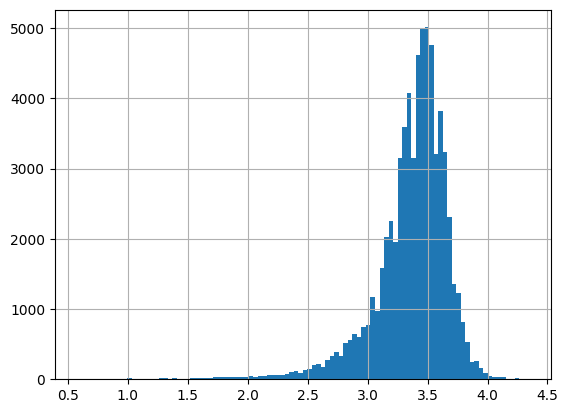

In [31]:
df_rym['rating'].hist(bins=100)

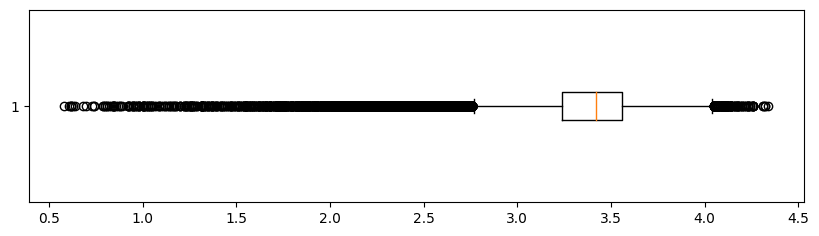

In [32]:
_, ax1 = plt.subplots(1, 1, figsize=(10, 2.5))
ax1.boxplot(df_rym['rating'], vert=False)
plt.show()

### 2.2 Cut and scale ratings
Cut and scale ratings for better distribution.
Compare original, scaled and manually set ratings.

In [33]:
df_ratings = scale_ratings(df_rym)

In [34]:
# Stats
print(f'Cutted IQR: {scipy.stats.iqr(df_ratings.rating).round(3)}')
print(f'Scaled IQR: {scipy.stats.iqr(df_ratings.scaled_rating).round(3)}')
print(f'Manual intervals IQR: {scipy.stats.iqr(df_ratings.manual).round(3)}')
df_ratings[['rating', 'scaled_rating', 'manual']].describe()

Cutted IQR: 0.32
Scaled IQR: 0.489
Manual intervals IQR: 1.0


,rating,scaled_rating,manual
count,68092.000000,68092.000000,68092.000000
mean,3.363442,3.506791,3.414843
std,0.315363,0.482206,0.707994
min,1.070000,0.000000,0.500000
25%,3.240000,3.318043,3.000000
50%,3.420000,3.593272,3.500000
75%,3.560000,3.807339,4.000000
max,4.340000,5.000000,5.000000


In [35]:
# Quantiles
print(df_ratings['rating'].quantile(q=0.05))  # top 95% (5%) - very bad - 0.0 // 0.1
print(df_ratings['rating'].quantile(q=0.2))  #  top 80% (15%) - bad     - 1.0 // 20
print(df_ratings['rating'].quantile(q=0.4))  #  top 60% (20%) - avg     - 2.0
print(df_ratings['rating'].quantile(q=0.6))  # top 40% (30%) - fine    - 3.0 // 30
print(df_ratings['rating'].quantile(q=0.95))  # top 5% (25%) - good     - 4.0 // 30
#                                              above (5%) - very good   - 5.0 // 10

2.79
3.19
3.36
3.48
3.74


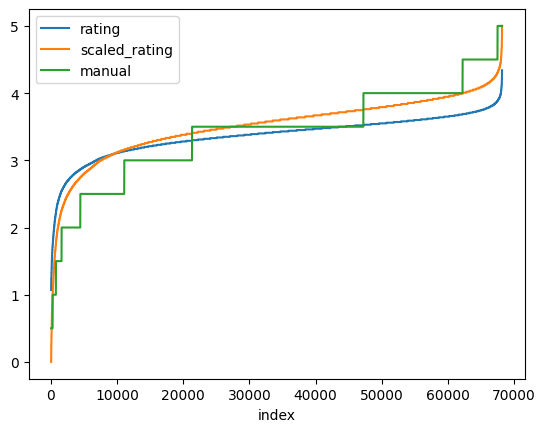

In [36]:
# Ratings values on chart
df_ratings['index'] = df_ratings.index
df_ratings.plot(x='index', y=['rating', 'scaled_rating', 'manual'])

plt.savefig("../../docs/master_thesis/06_rozklad_ocen.svg")

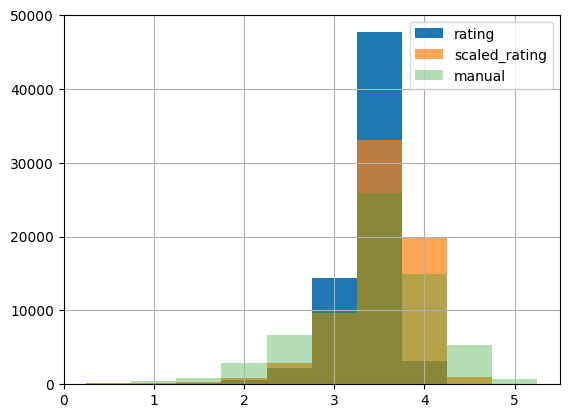

In [37]:
# Histogram
bins = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]) / 2
df_ratings['rating'].hist(bins=bins, alpha=1, legend=True)
df_ratings['scaled_rating'].hist(bins=bins, alpha=0.7, legend=True)
df_ratings['manual'].hist(bins=bins, alpha=0.35, legend=True)

plt.savefig("../../docs/master_thesis/07_histogram_ocen.svg")

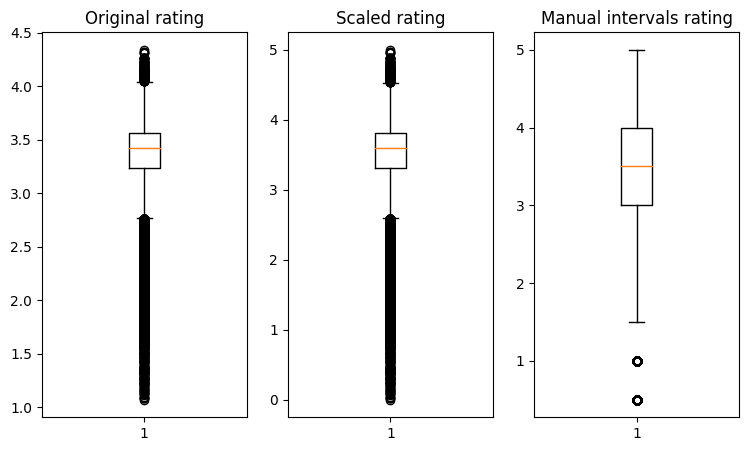

In [38]:
# Box plots
plot_box_plots(df_ratings)


### Conclusion
- As an average value, there is problem with distribution of ratings - over 75% of rating data is between 3 and 4 rate.
- MinMaxScaler slightly helps, but still doesn't eliminate the problem.
- Manual intervals show best results, but boundaries are handcrafted by a human and the problem is converted from continuous values to defined classes - for further investigation.

## 3. Genres

In [39]:
df_genres: pd.DataFrame = df_raw_rym['genres'].str.get_dummies(sep=',')
genres = df_genres.columns.values

In [40]:
all_genres_sum = df_genres.sum()
rare_genres = all_genres_sum[all_genres_sum < 5].index
df_clear_genres = df_genres.loc[
    df_genres.drop(rare_genres, axis=1).sum(axis=1) != 0
    ].drop(rare_genres, axis=1)

In [41]:
print(f'All genres: {len(genres)}')
print(f'All genres that occur less than 5 times: {len(rare_genres)}')

All genres: 2357
All genres that occur less than 5 times: 873


In [42]:
df_genre = pd.read_csv('../../data/feature/rym_1965_2022.csv')

In [43]:
df_genre.drop(['album_id', 'rating', 'decade'], axis=1).sum()

ambient                236
blues                  291
classical              499
comedy                 109
country                956
dance                 2742
electronic            5241
experimental          3945
folk                  2909
hiphop                3509
industrial            1086
jazz                  2334
metal                 9696
pop                  11773
punk                  5933
r&b                   3273
regional              4171
rock                 22172
singer-songwriter      284
ska                    121
unknown                991
dtype: int64

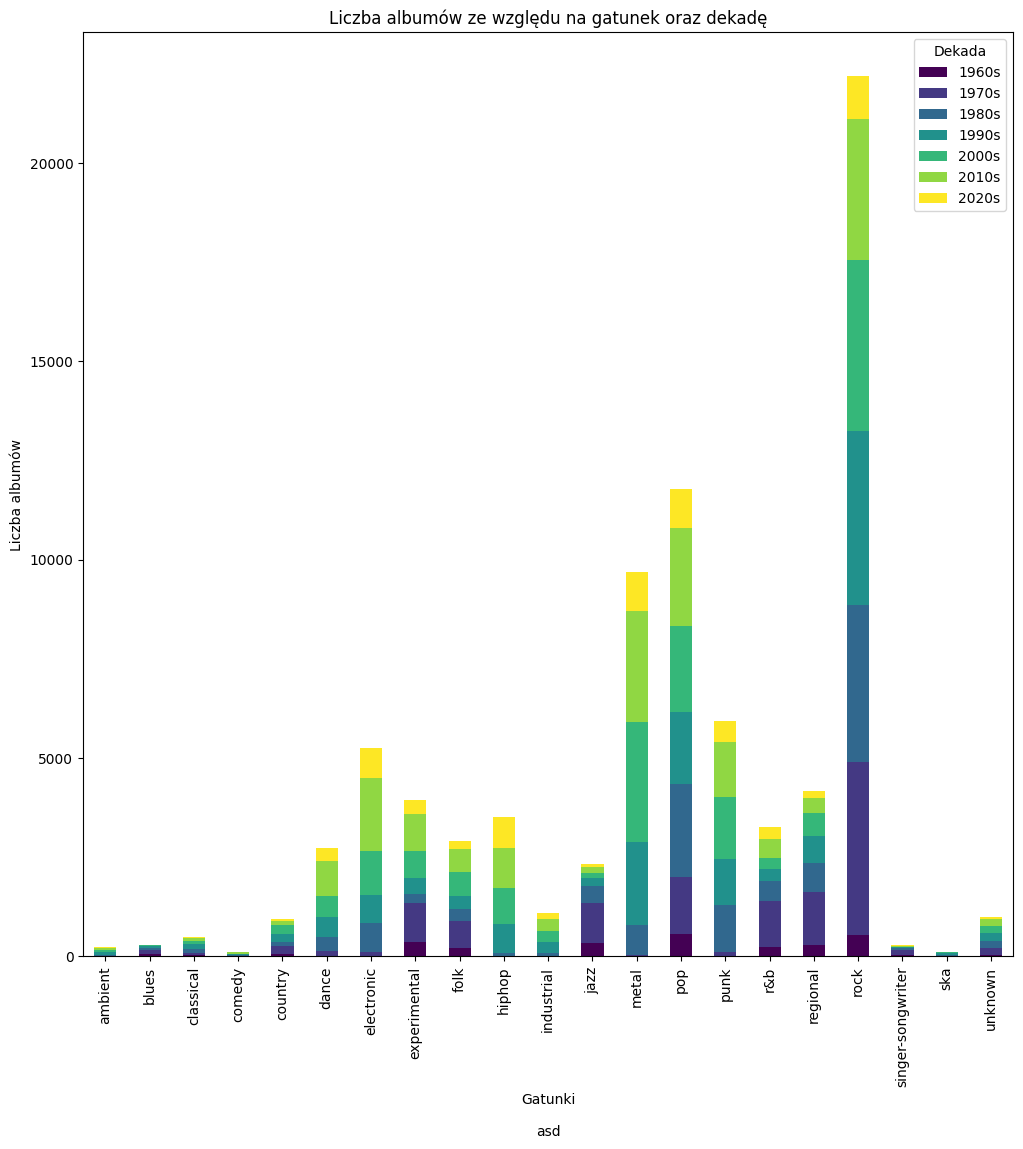

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df_genre = pd.read_csv('../../data/feature/rym_1965_2022.csv')
df_genre['decade'] = (round(df_genre['decade'] * 60) + 1960).astype(int)

# Group the data by 'decade' and sum the values for each decade
decade_grouped = df_genre.drop(['album_id', 'rating'], axis=1).groupby('decade').sum()

# Plot a grouped bar chart with different colors for each decade
ax = decade_grouped.transpose().plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 12))

# Add labels and a legend
plt.xlabel('Gatunki\n\nasd')
plt.ylabel('Liczba albumów')
plt.title('Liczba albumów ze względu na gatunek oraz dekadę')
legend_labels = ['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
ax.legend(legend_labels, title='Dekada')

# Show the plot
plt.savefig("../../docs/master_thesis/4_5_gatunki.svg")
plt.show()


### Conclusion
- Too many genres to use them as features.
- Genres should be mapped to the most similar manually selected genre.
- Single genre could be split into main genre and sub-genre adjective like 'punk rock' into 'rock' and 'punk'.
- List of genres to map: [https://rateyourmusic.com/genres/](https://rateyourmusic.com/genres/)